# 基础实验1: 图像底层处理与图像分割-week2
图像分割（image segmentation）技术是计算机视觉领域的个重要的研究方向，是图像语义理解的重要一环。Normalize cut是基于图论的图像分割方法中最为经典的方法之一。在本次实验中，你将学习了解normalize cut的实现细节，并对此方法中的关键步骤进行改进。

参考文献：https://repository.upenn.edu/cgi/viewcontent.cgi?article=1101&context=cis_papers

你将学习：
- 使用图论思想进行图像分割
- （可选的）使用稀疏矩阵优化原始算法


首先，我们从加载本实验必须的python库开始：

In [11]:
import numpy as np
import skimage
import skimage.io
from scipy import sparse
from scipy.sparse.linalg import eigs,svds
from scipy.linalg import fractional_matrix_power
import matplotlib.pyplot as plt
from time import *
import cv2

## 1. 算法解析
图像分割是一个传统的问题，但是分割的好坏却很难度量。Normalize cut提出了一种基于图论的准则来衡量图像分割的优良性，并将图像分割问题转化为求解图的最小割问题。

理解什么是最小割问题需要首先明确什么是割：对于一张无向带权图$G = (V, E, w)$，若存在边集$C$，将点集$V$分为点集$S$和点集$T$，满足$S\cup T = V$，$S\cap T = \emptyset$，$C$中任何一条边的两个端点分别属于$S$和$T$中，那么称$C = (S, T)$是图$G$的一个割（也称作割集）。最小割指的就是边权值之和最小的割集，最小割问题就是要求解最小割。

在图像分割问题中，定义最小割问题的目标函数可以这样表示：
$$
W(C)=\sum_{u\in S,v\in T,(u,v)\in E}w(u,v)
$$

求解最小割问题的具体方法不是计算机视觉课程的重点，我们在此跳过最小割问题的求解细节，转而思考：

**<center>为什么图像分割问题可以转化为图论中无向带权图的最小割问题?</center>**

观察下面的例子不难发现，图像中大部分位置相近的像素的值是接近的，图像的像素值之间存在明显差异的位置就是理想的“边界”。因此，一个直观且合理的分割的原则就是使划分后的子图在内部保持相似度最大，而子图之间的相似度保持最小。

<img src="src/plane2.jpg" style="width:500px;height:500;">

属于同一区域的像素点之间，边权值一定是非常大的（因此这些权值很大的边不可能存在于最小割集中），而不同区域之间的边权值肯定很小，比如白色的飞机机身区域与绿色的草坪区域边界线上的边权值，一定是很小的值，这就是为什么我们需要求最小割集来解决图像分割问题。

<img src="lecture_img/min-cut.png" style="width:500px;height:500;">

但是仅用上文提到的目标函数来做图像分割时, 往往会出现分割单个点的情况，如下图所示：

<img src="lecture_img/bad-cut.png" style="width:500px;height:500;">

可以看到，普通的最小割算法会更加倾向于做Min-cut1和Min-cut2这样的分割，因为单个像素点所组成的点集，与其他点集相邻的边一般是最少的，所以边权值之和往往也是最小的，这样一来，结果往往是分割出了一个个孤立的像素点，实验结果并不理想。我们真正想要的图像分割，实际上是类似图中better cut这样的。

为了解决上文所提到的问题，Wu等人改进了原始最小割问题的目标函数：

$$
Ncut(A,B)=\frac{cut(A,B)}{assoc(A,V)}+\frac{cut(A,B)}{assoc(B,V)}
$$

其中$A$, $B$均为点集，$V$为整个图像的总像素点集。$A\cap B = \emptyset$。$cut(A, B)$就是分割$A，B$两集合的割集的权值和，$assoc(A , V)$表示$A$中所有点与图中所有点（即点集$V$）相连的边的权值和。引入$assoc$这个函数后，就能比较好地避免分割出孤立点的情况。



## 2. 算法实现

### 2.1 生成无向带权图
首先，读取src目录下的测试图像，resize到100\*100大小（为了降低计算时间）

In [12]:
img = skimage.img_as_ubyte(skimage.io.imread('./src/test.jpg',as_gray=True))#smaller than 100*100px better
img = cv2.resize(img, (50,50))
print(img.shape)

(50, 50)


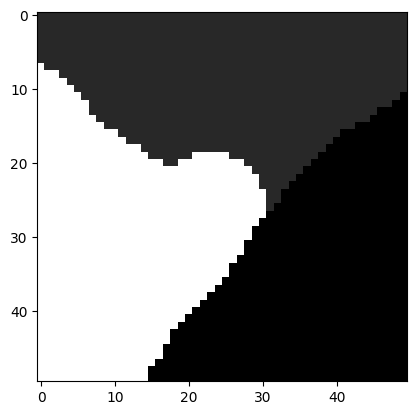

In [13]:
plt.imshow(img, cmap='gray')  # 指定灰度色图

**练习**：现在，你需要补全下面的generate_W函数，实现为一张图像生成无向带权图的功能

**要求**: 
- 输入img：一张包含N个像素点的灰度图像
- 输出W：输入图像的无向带权图（一个N\*N的numpy矩阵格式）
- 任意两个像素点之间的距离$w_{i,j}$按照下列公式进行计算：

$$
w_{i,j}=e^{\frac{-||F(i)-F(j)||_2^2}{\sigma_I}}*\left\{
\begin{aligned}
&e^{\frac{-||X(i)-X(j)||_2^2}{\sigma_X}}\ &\text{if} \ ||X(i)-X(j)||_2\leq r\\
&0\ &\text{otherwise}
\end{aligned}
\right.
$$

其中，$X(i)$是像素点i的空间位置，$F(i)$是$i$的特征（像素值、颜色或者纹理特征），$\sigma_I,\sigma_X$是超参数。空间距离超过r的像素之间的关系不会被考虑，即：权重被设置为0。

In [14]:
def generate_W(img):
    N = len(img)
    d = np.zeros((N, N), dtype=np.uint8)
    
    ### START CODE HERE ###
    
    
    
    ### END CODE HERE ###

    # 这里给出一个过度简化了的答案，仅供参考
    # 在你完成实验时请删掉下面的代码
    
    ### CODE TO BE DELETE BEGIN ###
    for i in range(N):
        d[i, :] = np.abs(img - img[i])
    W = np.exp(-np.power(d / np.max(d), 2))
    ### CODE TO BE DELETE END ###
    
    return W

你可以通过执行下面的代码来对编写好的函数进行测试：

In [15]:
W = generate_W(img.flatten())
print(W.shape)
np.set_printoptions (precision= 3)
print(W)

(2500, 2500)
[[1.    1.    1.    ... 0.368 0.368 0.368]
 [1.    1.    1.    ... 0.368 0.368 0.368]
 [1.    1.    1.    ... 0.368 0.368 0.368]
 ...
 [0.994 0.994 0.994 ... 1.    1.    1.   ]
 [0.994 0.994 0.994 ... 1.    1.    1.   ]
 [0.994 0.994 0.994 ... 1.    1.    1.   ]]


### 2.2 求解最小割问题

在这一部分中，我们重点研究normalize cut中的归一化项$assoc(A,V),assoc(B,V)$是如何计算的，暂且不关心详细的数学推导过程。

求解使得normalize cut目标函数：

$$
Ncut(A,B)=\frac{cut(A,B)}{assoc(A,V)}+\frac{cut(A,B)}{assoc(B,V)}
$$

其中：
- $cut(A,B)$表示子集$A$和$B$之间的割，即子集$A$和$B$之间的权重之和
- $assoc(A,V)$表示子集$A$与整个图$V$的关联度，定义为$A$中所有点与$V$中所有点的权重之和，即：
$$
\operatorname{assoc}(A, V)=\sum_{i \in A} \sum_{j \in V} w(i, j)
$$
- 同理，$assoc(B, V)=\sum_{i \in B} \sum_{j \in V} w(i, j)$

在实际计算中，$assoc(A, V)$和$assoc(B, V)$通过权重矩阵 $𝑊$和对角矩阵$𝐷$来间接体现。$𝐷$的对角元素$d(i)=\sum_j w(i,j)$表示第 $i$ 个像素与所有像素的权重之和，因此 $assoc(A,V)$ 可以看作是 $A$ 中所有像素对应的$d(i)$ 的总和。

最小的分割的问题是NP-Hard的，可能需要指数级的计算时间开销。通过近似，可以把原始问题转化为下面的矩阵特征值求解问题：

$$
\mathbf{D}^{-\frac{1}{2}}(\mathbf{D}-\mathbf{W})\mathbf{D}^{-\frac{1}{2}}z=\lambda z
$$

其中
- $D$是对角矩阵，其对角元素$d(i)=\sum_j w(i,j)$

- $W$就是2.1中得到的权重。

- z 是特征向量（eigenvector），它是特征值问题的一个解。具体来说：z 是一个长度为 N 的向量，其中 N 是图中节点（像素）的总数。z 的每个分量z[i] 对应于图中第 i 个节点（像素），表示该节点在分割中的某种“归属度”或“指示值”。通过分析 z 的值（例如正负或大小），我们可以将图的节点分为两个子集（如 A 和 B），从而实现图像分割。


**练习**：现在，你需要补全下面的n_cuts函数，实现normalize cut的具体求解过程

**要求**: 
- 输入W：2.1中得到的无向带权图（一个N\*N的numpy矩阵）

In [ ]:
def n_cuts(W):
    
    ### START CODE HERE ###
    
    
    
    ### END CODE HERE ###
    
    # 这里给出一个过度简化了的答案，仅供参考
    # 在你完成实验时请删掉下面的代码
    
    ### CODE TO BE DELETE BEGIN ###
    tmp = np.ones((2500, 2500), dtype=np.uint8)# 与图像大小对应
    D = np.sum(tmp, axis=1)
    #print(D.shape)
    D = np.diag(D)
    #print(D.shape)
    ### CODE TO BE DELETE END ###
    
    D_nhalf = fractional_matrix_power(D, -0.5)
    L = D_nhalf @ (D - W) @ D_nhalf
    #eigenvalues, eigenvectors = eigs(L,2,which='SM')
    #eigenvectors = np.transpose(eigenvectors)
    _, eigenvalues, eigenvectors = svds(L,which='SM')#svd much faster than eig(lanczos method)
    plt.figure()
    for i in range(5):#分别使用前五个特征向量作为分割依据
        vec = eigenvectors[i+1] # 第i+1个特征向量作为分割依据
        # 使用 0 作为分割阈值，将特征向量分为两部分
        Partition_1 = vec > 0
        plt.subplot(1, 5, i+1)
        # 将分割结果重塑为图像形状并显示
        skimage.io.imshow(Partition_1.reshape(img.shape))
    plt.show()

运行下面的代码进行测试，可能需要几分钟的时间进行计算

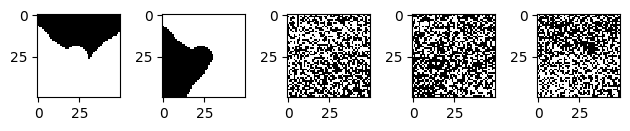

In [17]:
W = generate_W(img.flatten())
n_cuts(W)

## 3.（可选）优化N-cut的计算效率


在目前的代码实现中，即使对100\*100的图像进行分割也需要几分钟的时间，在这部分可选任务中，你可以尝试借助一些图像以及矩阵运算的性质优化N-cut的计算效率，从而实现对大尺寸图像的快速分割。

可能你已经注意到，权重计算公式中，由于r的存在，权重矩阵W中大部分元素都是0：

$$
w_{i,j}=e^{\frac{-||F(i)-F(j)||_2^2}{\sigma_I}}*\left\{
\begin{aligned}
&e^{\frac{-||X(i)-X(j)||_2^2}{\sigma_X}}\ \text{if}\ &||X(i)-X(j)||_2\leq r\\
&0\ &\text{otherwise}
\end{aligned}
\right.
$$

这意味着W是高度稀疏的矩阵，特征值的求解过程中大部分和0元素的运算都是可以省去的。

**练习**：现在，你需要补全下面的fast_n_cuts函数，实现normalize cut的快速求解

**要求**: 
- 输入W：2.1中得到的无向带权图（一个N\*N的numpy矩阵）
- 输出：求解后得到的特征值与特征向量
- 时间：对于100\*100的图像，你的程序应该可以在10s之内完成计算

In [18]:
def fast_n_cuts(W):
    
    ### START CODE HERE ###
    
    
    
    ### END CODE HERE ###
    
    _, eigenvalues, eigenvectors = svds(L,which='SM')#svd much faster than eig(lanczos method)
    plt.figure()
    for i in range(5):
        Partition_1 = eigenvectors[i+1] > 0#choose 0 as split point, which can also be replaced by np.median(eigenvectors[i+1])
        plt.subplot(1, 5, i+1)
        # cut_area = image*Partition_1.reshape(image.shape)
        # skimage.io.imshow(cut_area)
        skimage.io.imshow(Partition_1.reshape(img.shape))
    plt.show()

In [ ]:
W = generate_W(img.flatten())
fast_n_cuts(W)

NameError: name 'image' is not defined